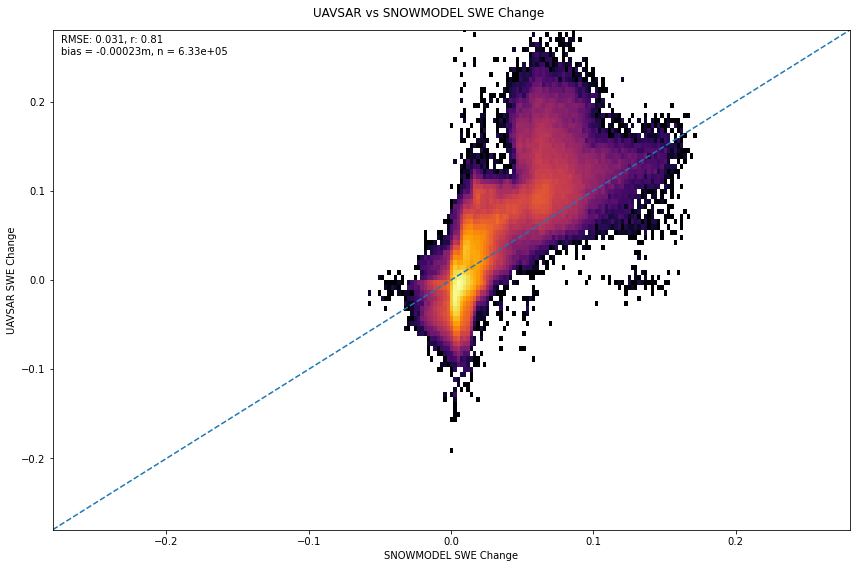

In [64]:
# loop through each flight pair and calculate rmse, r2, plot

import xarray as xr
import numpy as np
import rioxarray as rxa
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path

# loop through each flight pair and calculate rmse, r2, plot

ncs_dir = Path('/bsuscratch/zacharykeskinen/data/uavsar/ncs/model')

fig, ax = plt.subplots(1, 1, figsize = (12, 8))
band = 'VV'
var = 'unw'

xs = []
ys = []
var = f'uavsar_dSD_{var}'
for fp in ncs_dir.glob('*.sd.model.nc'):
    ds = xr.open_dataset(fp)
    if f'uavsar_dSD_unw' in ds.data_vars:
        if ds['swe'].mean() < 0:
            continue
        ds = ds.sel(band = 'VV')
        # ds = ds.where(ds['lc'].isin(open))
        # ds = ds.where(id_tree < 20)
        ds = ds.where(ds['swe_t1'] > 0.05)
        # ds = ds.where(ds['cor'] > 0.45)
        # ds = ds.where(ds['swe'] > 0)
        dSWE = ds['uavsar_dSD_unw'] *  ds.attrs['mean_density'] / 997
        # dSWE = dSWE + (ds['swe'].mean() - dSWE.mean())
        xs.append(ds['swe'].values.ravel())
        ys.append(dSWE.values.ravel())

# stack arrays
xs = np.hstack(xs)
ys = np.hstack(ys)

xs_tmp = xs[(~np.isnan(xs)) & (~np.isnan(ys))]
ys = ys[(~np.isnan(xs)) & (~np.isnan(ys)) ]
xs = xs_tmp

# range = [[-0.001, 0.002], [-0.1, 0.1]]
ax.hist2d(xs, ys, bins = 100, norm=mpl.colors.LogNorm(), cmap=mpl.cm.inferno) #, range = range)


from stats import get_stats
rmse, r, n, bias = get_stats(xs, ys, bias = True)
ax.text(.01, .99, f'RMSE: {rmse:.2}, r: {r:.2}\nbias = {bias:.2}m, n = {n:.2e}', ha='left', va='top', transform=ax.transAxes)
plt.suptitle('UAVSAR vs SNOWMODEL SWE Change')

ax.set_ylabel('UAVSAR SWE Change')
ax.set_xlabel('SNOWMODEL SWE Change')
# identity line

ax.plot([-1,1], [-1,1], label = '1-to-1', linestyle = 'dashed')
ax.set_xlim(-0.28, 0.28)
ax.set_ylim(-0.28, 0.28)

plt.tight_layout()
plt.savefig('/bsuhome/zacharykeskinen/uavsar-validation/figures/model/modeling_all_v2.png')

next

100%|██████████| 10/10 [00:21<00:00,  2.17s/it]


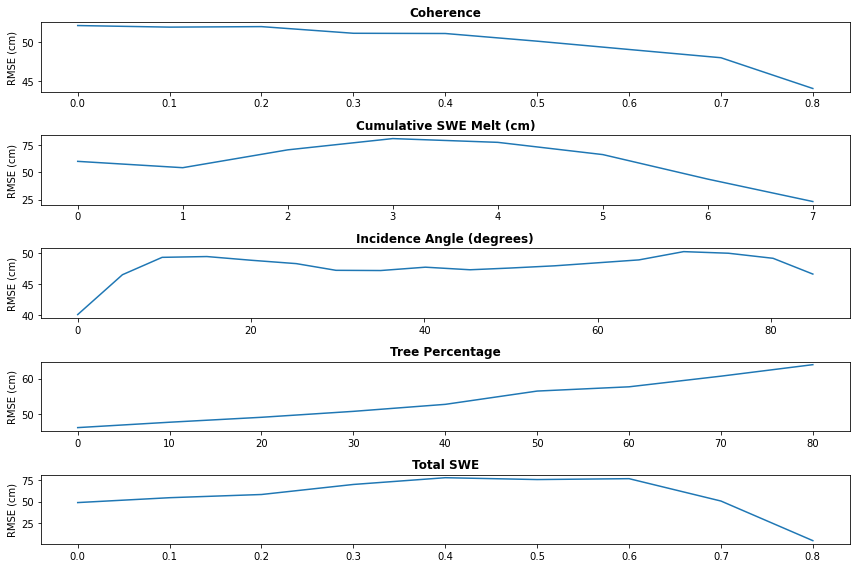

In [9]:
from stats import get_stats
import xarray as xr
import numpy as np
import rioxarray as rxa
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

def clean_xs_ys(xs, ys):
        # stack arrays
    xs = np.hstack(xs)
    ys = np.hstack(ys)

    xs_tmp = xs[(~np.isnan(xs)) & (~np.isnan(ys)) & (np.isfinite(xs)) & (np.isfinite(ys))]
    ys = ys[(~np.isnan(xs)) & (~np.isnan(ys))  & (np.isfinite(xs)) & (np.isfinite(ys))]
    xs = xs_tmp

    return xs, ys

def make_iter(start, end, step):
    lows = np.round(np.arange(start, end, step), 2)
    highs = np.round(np.arange(step, end + step, step), 2)
    iters = zip(lows, highs)
    return iters, len(lows)

ncs_dir = Path('/bsuscratch/zacharykeskinen/data/uavsar/ncs/model')

fig, axes = plt.subplots(5, figsize = (12, 8))
var = f'uavsar_dSD_unw'
band = 'VV'

# coherence
iters, n = make_iter(0, 0.9, 0.1)
rmses = []
lows = []
for i, (low, high) in enumerate(tqdm(iters, total = n)):
    xs = []
    ys = []

    for fp in ncs_dir.glob('*.sd.model.nc'):
        ds = xr.open_dataset(fp)
        ds = ds.where((ds['cor'].sel(band = band) < high) & (ds['cor'].sel(band = band) > low))

        if var in ds.data_vars:
            xs.append(ds['swe'].values.ravel())
            ys.append(ds[var].sel(band = band).values.ravel() * (ds.attrs['mean_density']/ 997))
    xs, ys = clean_xs_ys(xs, ys)

    if len(xs) < 50:
        continue

    rmse, r, n = get_stats(xs, ys)
    rmses.append(r)
    lows.append(low)

ax_cor = axes[0]
ax_cor.plot(lows, np.multiply(rmses, 100))
ax_cor.set_title('Coherence', weight = 'bold')

# snow wetness
iters, n = make_iter(0, 0.075, 0.01) #0.01
rmses = []
lows = []
for i, (low, high) in enumerate(tqdm(iters, total = n)):
    xs = []
    ys = []

    for fp in ncs_dir.glob('*.sd.model.nc'):
        ds = xr.open_dataset(fp)
        ds = ds.where((ds['cum_melt'] < high) & (ds['cum_melt'] > low))

        if var in ds.data_vars:
            xs.append(ds['swe'].values.ravel())
            ys.append(ds[var].sel(band = 'VV').values.ravel() * (ds.attrs['mean_density']/ 997))
    xs, ys = clean_xs_ys(xs, ys)

    if len(xs) < 50:
        continue
    rmse, r, n = get_stats(xs, ys)
    rmses.append(r)
    lows.append(low * 100)

ax_melt = axes[1]
ax_melt.plot(lows, np.multiply(rmses, 100))
ax_melt.set_title('Cumulative SWE Melt (cm)', weight = 'bold')

# incidence angle
iters, n = make_iter(0, np.deg2rad(90), np.deg2rad(5))
rmses = []
lows = []
for i, (low, high) in enumerate(tqdm(iters, total = n)):
    xs = []
    ys = []

    inc = xr.open_dataset(next(ncs_dir.glob('*.sd.model.nc')))['inc']
    for fp in ncs_dir.glob('*.sd.model.nc'):
        ds = xr.open_dataset(fp)
        ds = ds.where((inc < high) & (inc > low))

        if var in ds.data_vars:
            xs.append(ds['swe'].values.ravel())
            ys.append(ds[var].sel(band = 'VV').values.ravel() * (ds.attrs['mean_density']/ 997))
    xs, ys = clean_xs_ys(xs, ys)

    if len(xs) < 50:
        continue
    rmse, r, n = get_stats(xs, ys)
    rmses.append(r)
    lows.append(np.round(np.rad2deg(low), 2))

ax_inc = axes[2]
ax_inc.plot(lows, np.multiply(rmses, 100))
ax_inc.set_title('Incidence Angle (degrees)', weight = 'bold')

# tree coverage
if 'id_tree' not in locals():
    trees = rxa.open_rasterio('/bsuhome/zacharykeskinen/scratch/data/uavsar/trees/nlcd/nlcd_2016_treecanopy_2019_08_31.img').squeeze('band')
    trees_clip = trees.rio.clip_box(*ds.rio.bounds(), crs = ds.rio.crs)
    id_tree = trees.rio.reproject_match(ds['inc'])

iters, n = make_iter(0, 100, 10)
rmses = []
lows = []
for i, (low, high) in enumerate(tqdm(iters, total = n)):
    xs = []
    ys = []

    for fp in ncs_dir.glob('*.sd.model.nc'):
        ds = xr.open_dataset(fp)
        ds = ds.where((id_tree < high) & (id_tree > low))

        if var in ds.data_vars:
            xs.append(ds['swe'].values.ravel())
            ys.append(ds[var].sel(band = 'VV').values.ravel() * (ds.attrs['mean_density']/ 997))
    xs, ys = clean_xs_ys(xs, ys)

    if len(xs) < 50:
        continue
    rmse, r, n = get_stats(xs, ys)
    rmses.append(r)
    lows.append(np.round(low, 2))

ax_tree = axes[3]
ax_tree.plot(lows, np.multiply(rmses, 100))
ax_tree.set_title('Tree Percentage', weight = 'bold')

# total swe
iters, n = make_iter(0, 1, 0.1)
rmses = []
lows = []
for i, (low, high) in enumerate(tqdm(iters, total = n)):
    xs = []
    ys = []

    for fp in ncs_dir.glob('*.sd.model.nc'):
        ds = xr.open_dataset(fp)
        ds = ds.where((ds['swe_t2'] < high) & (ds['swe_t2'] > low))

        if var in ds.data_vars:
            xs.append(ds['swe'].values.ravel())
            ys.append(ds[var].sel(band = 'VV').values.ravel() * (ds.attrs['mean_density']/ 997))
    xs, ys = clean_xs_ys(xs, ys)

    if len(xs) < 50:
        continue
    rmse, r, n = get_stats(xs, ys)
    rmses.append(r)
    lows.append(np.round(low, 2))

ax_swe = axes[4]
ax_swe.plot(lows, np.multiply(rmses, 100))
ax_swe.set_title('Total SWE', weight = 'bold')

# set all axes
for ax in axes:
    ax.set_ylabel('RMSE (cm)')
    # ax.set_ylim(2.7, 5.35)

plt.tight_layout()
# plt.savefig('/bsuhome/zacharykeskinen/uavsar-validation/figures/model/rmse_param_plots_v3.png')

In [49]:
# loop through each flight pair and calculate rmse, r2, plot

import xarray as xr
import numpy as np
import pandas as pd
import rioxarray as rxa
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path

from stats import clean_xs_ys, get_stats

# loop through each flight pair and calculate rmse, r2, plot

ncs_dir = Path('/bsuscratch/zacharykeskinen/data/uavsar/ncs/model')

xs = []
ys = []

temporal_rmse = pd.DataFrame(columns = ['days', 'rmse'])

band = 'VV'
var = f'uavsar_dSD_unw'
for i, fp in enumerate(ncs_dir.glob('*.sd.model.nc')):
    heading, d1, d2 = fp.stem.strip('.sd.model').split('_')
    d1, d2 = pd.to_datetime(d1), pd.to_datetime(d2)
    ds = xr.open_dataset(fp)
    if var not in ds.data_vars:
        continue

    xs = ds['swe'].values.ravel()
    ys = ds[var].sel(band = band).values.ravel() * (ds.attrs['mean_density']/ 997)

    rmse, r, n = get_stats(xs, ys)

    temporal_rmse.loc[i, 'd1'] = d1
    temporal_rmse.loc[i, 'd2'] = d2
    temporal_rmse.loc[i, 'heading'] = heading
    temporal_rmse.loc[i, 'days'] = (d2 - d1).days
    temporal_rmse.loc[i, 'rmse'] = rmse
    temporal_rmse.loc[i, 'mean_swe_change'] = ds['swe'].mean().data.ravel()[0]

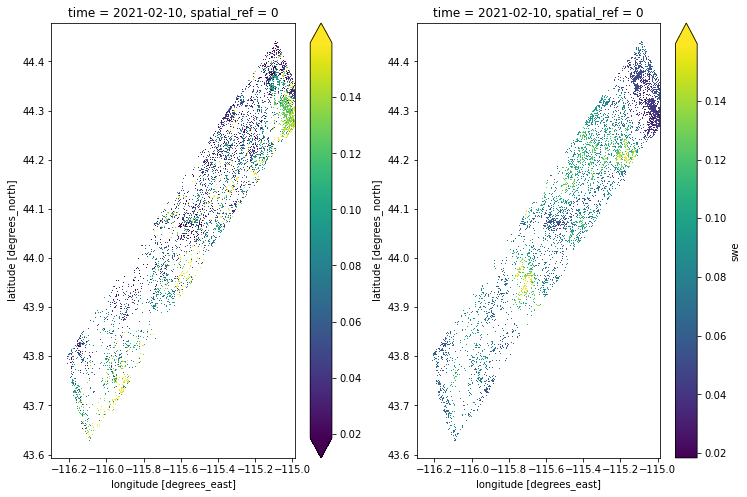

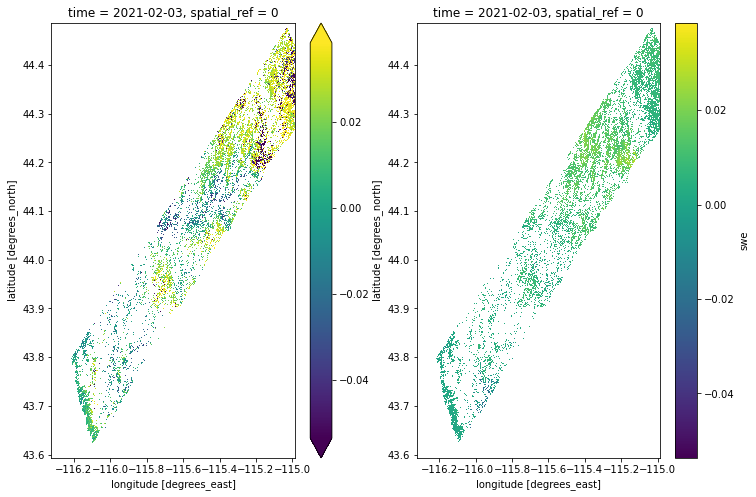

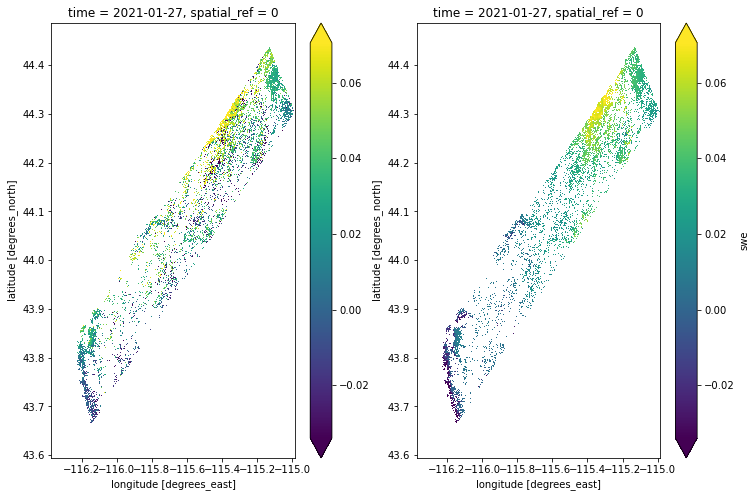

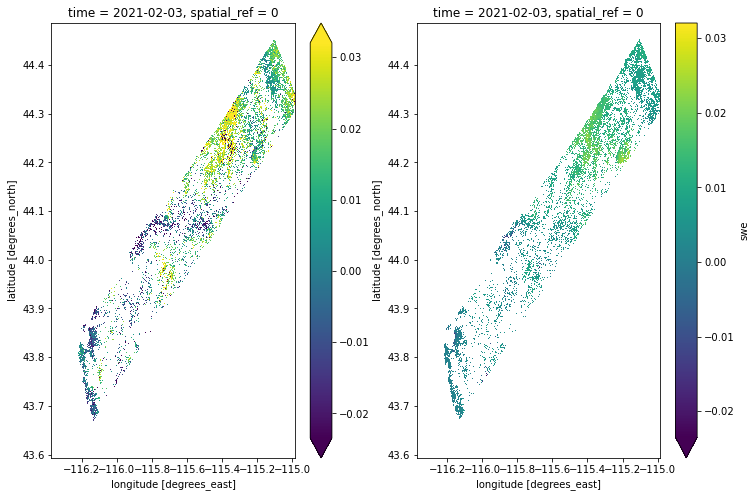

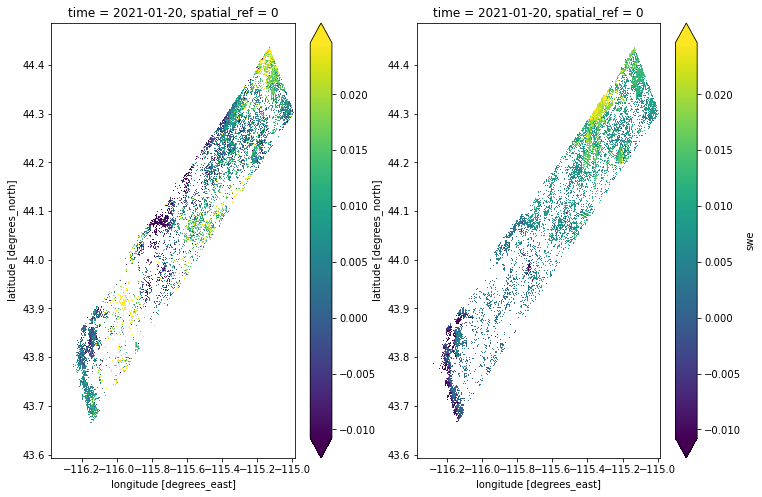

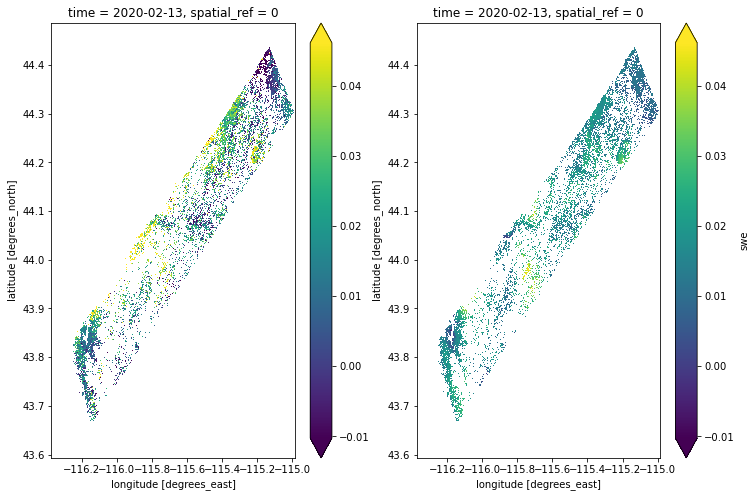

In [55]:
# loop through each flight pair and calculate rmse, r2, plot

import xarray as xr
import numpy as np
import pandas as pd
import rioxarray as rxa
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
import xskillscore as xs

from stats import clean_xs_ys, get_stats

open = [12, 31, 52, 71]
# loop through each flight pair and calculate rmse, r2, plot

ncs_dir = Path('/bsuscratch/zacharykeskinen/data/uavsar/ncs/model')

res = []
ints = []

band = 'VV'
var = f'uavsar_dSD_unw'
for i, fp in enumerate(ncs_dir.glob('*.sd.model.nc')):

    heading, d1, d2 = fp.stem.strip('.sd.model').split('_')
    d1, d2 = pd.to_datetime(d1), pd.to_datetime(d2)
    ds = xr.open_dataset(fp)
    if var not in ds.data_vars:
        continue
    rmse = xs.rmse(ds['uavsar_dSD_unw'].sel(band = 'VV')  * (ds.attrs['mean_density']/ 997), ds['swe'], dim = [], skipna = True)
    wrap = xs.rmse(ds['uavsar_dSD_int'].sel(band = 'VV'), ds['swe'], dim = [], skipna = True)
    if len(res) == 0:
        res = [rmse.expand_dims('time')]
        ints = [wrap.expand_dims('time')]
    else:
        res.append(rmse.expand_dims('time'))
        ints.append(wrap.expand_dims('time'))
    if ds['swe'].mean() > 0:
        fig, axes = plt.subplots(1, 2, figsize = (12, 8))
        ds = ds.sel(band = 'VV')
        # ds = ds.where(ds['lc'].isin(open))
        ds = ds.where(id_tree < 20)
        ds = ds.where(ds['swe_t1'] > 0.05)
        ds = ds.where(ds['cor'] > 0.45)
        dSWE = ds['uavsar_dSD_unw'] *  ds.attrs['mean_density'] / 997
        dSWE = dSWE + (ds['swe'].mean() - dSWE.mean())
        vmin, vmax = dSWE.quantile([0.05, 0.95]).data

        dSWE.plot(ax = axes[0], vmin = vmin, vmax = vmax)
        ds['swe'].where(~dSWE.isnull()).plot(ax = axes[1], vmin = vmin, vmax = vmax)
        # rmse.plot(ax = axes[2])
        plt.show()
rmse = xr.concat(res, dim = 'time').mean(dim = 'time', skipna = True).dropna('x', how = 'all').dropna('y', how = 'all')#.rolling(x = 3, y = 3).mean()
wrap = xr.concat(ints, dim = 'time').mean(dim = 'time', skipna = False).dropna('x', how = 'all').dropna('y', how = 'all').rolling(x = 3, y = 3).mean()
rmse = rmse.where(~wrap.isnull())

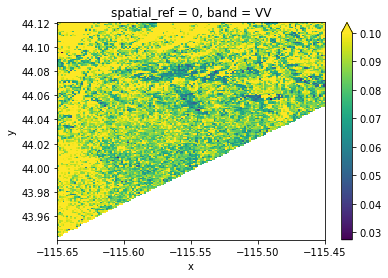

In [230]:
x1 = -115.65
x2 = -115.45
y1 = 43.94
y2 = 44.12
rmse.sel(x = slice(x1, x2), y = slice(y1, y2)).plot(vmax = 0.1)